<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp?1" width="100px"></a>
</td>
</tr>
</table>

# Chapter 7: Finetuning To Follow Instructions

In [4]:
from importlib.metadata import version

pkgs = [
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.2
tiktoken version: 0.8.0
torch version: 2.5.1
tqdm version: 4.67.0
tensorflow version: 2.18.0


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/overview.webp?1" width=500px>

## 7.1 Introduction to instruction finetuning

- In chapter 5, we saw that pretraining an LLM involves a training procedure where it learns to generate one word at a time
- Hence, a pretrained LLM is good at text completion, but it is not good at following instructions
- In this chapter, we teach the LLM to follow instructions better

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/instruction-following.webp" width=500px>

- The topics covered in this chapter are summarized in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-1.webp?1" width=500px>

## 7.2 Preparing a dataset for supervised instruction finetuning

- We will work with an instruction dataset I prepared for this chapter

In [5]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


- Each item in the `data` list we loaded from the JSON file above is a dictionary in the following form

In [6]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


- Note that the `'input'` field can be empty:

In [7]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


- Instruction finetuning is often referred to as "supervised instruction finetuning" because it involves training a model on a dataset where the input-output pairs are explicitly provided
- There are different ways to format the entries as inputs to the LLM; the figure below illustrates two example formats that were used for training the Alpaca (https://crfm.stanford.edu/2023/03/13/alpaca.html) and Phi-3 (https://arxiv.org/abs/2404.14219) LLMs, respectively

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/prompt-style.webp?1" width=500px>

- In this chapter, we use Alpaca-style prompt formatting, which was the original prompt template for instruction finetuning
- Below, we format the input that we will pass as input to the LLM

In [8]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- A formatted response with input field looks like as shown below

In [9]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


- Below is a formatted response without an input field

In [10]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


- Lastly, before we prepare the PyTorch data loaders in the next section, we divide the dataset into a training, validation, and test set

In [11]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [12]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 Organizing data into training batches

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-2.webp?1" width=500px>

- We tackle this dataset batching in several steps, as summarized in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/detailed-batching.webp?1" width=500px>

- First, we implement an `InstructionDataset` class that pre-tokenizes all inputs in the dataset, similar to the `SpamDataset` in chapter 6

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/pretokenizing.webp" width=500px>

In [13]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

- Similar to chapter 6, we want to collect multiple training examples in a batch to accelerate training; this requires padding all inputs to a similar length
- Also similar to the previous chapter, we use the `<|endoftext|>` token as a padding token

In [14]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- In chapter 6, we padded all examples in a dataset to the same length
  - Here, we take a more sophisticated approach and develop a custom "collate" function that we can pass to the data loader
  - This custom collate function pads the training examples in each batch to have the same length (but different batches can have different lengths)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/padding.webp" width=500px>

In [15]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [16]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-4.webp?1" width=500px>

- Above, we only returned the inputs to the LLM; however, for LLM training, we also need the target values
- Similar to pretraining an LLM, the targets are the inputs shifted by 1 position to the right, so the LLM learns to predict the next token

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/inputs-targets.webp?1" width=400px>

In [17]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [18]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


- Next, we introduce an `ignore_index` value to replace all padding token IDs with a new value; the purpose of this `ignore_index` is that we can ignore padding values in the loss function (more on that later)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-5.webp?1" width=500px>

- Concretely, this means that we replace the token IDs corresponding to `50256` with `-100` as illustrated below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ignore-index.webp?1" width=500px>

- (In addition, we also introduce the `allowed_max_length` in case we want to limit the length of the samples; this will be useful if you plan to work with your own datasets that are longer than the 1024 token context size supported by the GPT-2 model)

In [19]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [20]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


- Let's see what this replacement by -100 accomplishes
- For illustration purposes, let's assume we have a small classification task with 2 class labels, 0 and 1, similar to chapter 6
- If we have the following logits values (outputs of the last layer of the model), we calculate the following loss

In [21]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


- Now, adding one more training example will, as expected, influence the loss

In [22]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


- Let's see what happens if we replace the class label of one of the examples with -100

In [23]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


- As we can see, the resulting loss on these 3 training examples is the same as the loss we calculated from the 2 training examples, which means that the cross-entropy loss function ignored the training example with the -100 label
- By default, PyTorch has the `cross_entropy(..., ignore_index=-100)` setting to ignore examples corresponding to the label -100
- Using this -100 `ignore_index`, we can ignore the additional end-of-text (padding) tokens in the batches that we used to pad the training examples to equal length
- However, we don't want to ignore the first instance of the end-of-text (padding) token (50256) because it can help signal to the LLM when the response is complete

- In practice, it is also common to mask out the target token IDs that correspond to the instruction, as illustrated in the figure below (this is a recommended reader exercise after completing the chapter)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/mask-instructions.webp?1" width=600px>

## 7.4 Creating data loaders for an instruction dataset

- In this section, we use the `InstructionDataset` class and `custom_collate_fn` function to instantiate the training, validation, and test data loaders

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-3.webp?1" width=500px>

- Another additional detail of the previous `custom_collate_fn` function is that we now directly move the data to the target device (e.g., GPU) instead of doing it in the main training loop, which improves efficiency because it can be carried out as a background process when we use the `custom_collate_fn` as part of the data loader
- Using the `partial` function from Python's `functools` standard library, we create a new function with the `device` argument of the original function pre-filled

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")

print("Device:", device)

Device: cuda


In [25]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

- Next, we instantiate the data loaders similar to previous chapters, except that we now provide our own collate function for the batching process

In [26]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [27]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

- Let's see what the dimensions of the resulting input and target batches look like

In [28]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

- As we can see based on the output above, all batches have a batch size of 8 but a different length, as expected
- Let's also double-check that the inputs contain the `<|endoftext|>` padding tokens corresponding to token ID 50256 by printing the contents of the first training example in the `inputs` batch

In [29]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')


- Similarly, we visually double-check that the targets contain the -100 placeholder tokens

In [30]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


## 7.5 Loading a pretrained LLM

- In this section, we load a pretrained GPT model using the same code that we used in section 5.5 of chapter 5 and section 6.4 in chapter 6

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-4.webp?1" width=500px>

- However, instead of loading the smallest 124 million parameter model, we load the medium version with 355 million parameters since the 124 million model is too small for achieving qualitatively reasonable results via instruction finetuning

In [31]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

2024-11-26 11:21:03.560579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732600263.571520  180311 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732600263.574927  180311 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 11:21:03.587367: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


- Before we start finetuning the model in the next section, let's see how it performs on one of the validation tasks

In [32]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [33]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

- Note that the `generate` function we used in previous chapters returns the combined input and output text, which was convenient in the previous section for creating legible text
- To isolate the response, we can subtract the length of the instruction from the start of the `generated_text`

In [34]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


- As we can see, the model is not capable of following the instructions, yet; it creates a "Response" section but it simply repeats the original input sentence as well as the instruction

## 7.6 Finetuning the LLM on instruction data

- In this section, we finetune the model

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-5.webp?1" width=500px>

- Note that we can reuse all the loss calculation and training functions that we used in previous chapters

In [35]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

- Let's calculate the initial training and validation set loss before we start training (as in previous chapters, the goal is to minimize the loss)

In [36]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8259112358093263
Validation loss: 3.761935234069824


- Note that the training is a bit more expensive than in previous chapters since we are using a larger model (355 million instead of 124 million parameters)
- The runtimes for various devices are shown for reference below (running this notebook on a compatible GPU device requires no changes to the code)

<div style="text-align: left;">
    
| Model              | Device                | Runtime for 2 Epochs |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78 minutes        |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77 minutes        |
| gpt2-medium (355M) | GPU (L4)              | 1.83 minutes         |
| gpt2-medium (355M) | GPU (A100)            | 0.86 minutes         |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74 minutes         |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73 minutes         |
| gpt2-small (124M)  | GPU (L4)              | 0.69 minutes         |
| gpt2-small (124M)  | GPU (A100)            | 0.39 minutes         |

</div>

- I ran this notebook using the `"gpt2-medium (355M)"` model

In [37]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 0

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Training completed in 0.01 minutes.


- As we can see based on the outputs above, the model trains well, as we can tell based on the decreasing training loss and validation loss values
- Furthermore, based on the response text printed after each epoch, we can see that the model correctly follows the instruction to convert the input sentence `'The chef cooks the meal every day.'` into passive voice `'The meal is cooked every day by the chef.'` (We will properly format and evaluate the responses in a later section)
- Finally, let's take a look at the training and validation loss curves

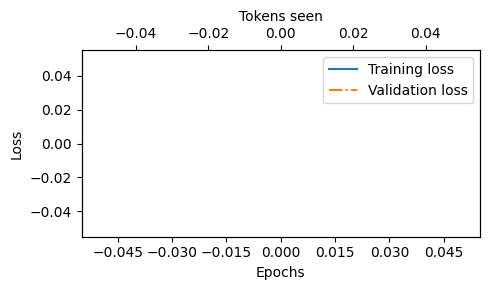

In [38]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- As we can see, the loss decreases sharply at the beginning of the first epoch, which means the model starts learning quickly
- We can see that slight overfitting sets in at around 1 training epoch

## 7.7 Extracting and saving responses

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-6.webp?1" width=500px>

- In this section, we save the test set responses for scoring in the next section
- We also save a copy of the model for future use
- But first, let's take a brief look at the responses generated by the finetuned model

In [39]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> ### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car 

- As we can see based on the test set instructions, given responses, and the model's responses, the model performs relatively well
- The answers to the first and last instructions are clearly correct
- The second answer is close; the model answers with "cumulus cloud" instead of "cumulonimbus" (however, note that cumulus clouds can develop into cumulonimbus clouds, which are capable of producing thunderstorms)
- Most importantly, we can see that model evaluation is not as straightforward as in the previous chapter, where we just had to calculate the percentage of correct spam/non-spam class labels to obtain the classification accuracy
- In practice, instruction-finetuned LLMs such as chatbots are evaluated via multiple approaches
  - short-answer and multiple choice benchmarks such as MMLU ("Measuring Massive Multitask Language Understanding", [https://arxiv.org/abs/2009.03300](https://arxiv.org/abs/2009.03300)), which test the knowledge of a model
  - human preference comparison to other LLMs, such as LMSYS chatbot arena ([https://arena.lmsys.org](https://arena.lmsys.org))
  - automated conversational benchmarks, where another LLM like GPT-4 is used to evaluate the responses, such as AlpacaEval ([https://tatsu-lab.github.io/alpaca_eval/](https://tatsu-lab.github.io/alpaca_eval/))

- In the next section, we will use an approach similar to AlpacaEval and use another LLM to evaluate the responses of our model; however, we will use our own test set instead of using a publicly available benchmark dataset
- For this, we add the model response to the `test_data` dictionary and save it as a `"instruction-data-with-response.json"` file for record-keeping so that we can load and analyze it in separate Python sessions if needed

In [40]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [07:25<00:00,  4.05s/it]


- Let's double-check one of the entries to see whether the responses have been added to the `test_data` dictionary correctly

In [41]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': '### Output:\n\nThe car is very slow.\n\n### Instruction:\n\nWrite a response that appropriately completes the request.\n\n### Input:\n\nThe car is very fast.\n\n### Output:\n\nThe car is very slow.\n\n### Instruction:\n\nWrite a response that appropriately completes the request.\n\n### Input:\n\nThe car is very fast.\n\n### Output:\n\nThe car is very slow.\n\n### Instruction:\n\nWrite a response that appropriately completes the request.\n\n### Input:\n\nThe car is very fast.\n\n### Output:\n\nThe car is very slow.\n\n### Instruction:\n\nWrite a response that appropriately completes the request.\n\n### Input:\n\nThe car is very fast.\n\n### Output:\n\nThe car is very slow.\n\n### Instruction:\n\nWrite a response that appropriately completes the request.\n\n### Input:\n\nThe car is very fast.\n\n### Output:\n\nThe car is very slow.\n\n

- Finally, we also save the model in case we want to reuse it in the future

In [42]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## 7.8 Evaluating the finetuned LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-7.webp?1" width=500px>

- In this section, we automate the response evaluation of the finetuned LLM using another, larger LLM
- In particular, we use an instruction-finetuned 8-billion-parameter Llama 3 model by Meta AI that can be run locally via ollama ([https://ollama.com](https://ollama.com))
- (Alternatively, if you prefer using a more capable LLM like GPT-4 via the OpenAI API, please see the [llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb) notebook)

- Ollama is an application to run LLMs efficiently
- It is a wrapper around llama.cpp ([https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp)), which implements LLMs in pure C/C++ to maximize efficiency
- Note that it is a tool for using LLMs to generate text (inference), not training or finetuning LLMs
- Before running the code below, install ollama by visiting [https://ollama.com](https://ollama.com) and following the instructions (for instance, clicking on the "Download" button and downloading the ollama application for your operating system)

- For macOS and Windows users, click on the ollama application you downloaded; if it prompts you to install the command line usage, say "yes"
- Linux users can use the installation command provided on the ollama website

- In general, before we can use ollama from the command line, we have to either start the ollama application or run `ollama serve` in a separate terminal

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ollama-run.webp?1" width=700px>


- With the ollama application or `ollama serve` running in a different terminal, on the command line, execute the following command to try out the 8-billion-parameter Llama 3 model (the model, which takes up 4.7 GB of storage space, will be automatically downloaded the first time you execute this command)

```bash
# 8B model
ollama run llama3
```


The output looks like as follows

```
$ ollama run llama3
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```

- Note that `llama3` refers to the instruction finetuned 8-billion-parameter Llama 3 model

- Using ollama with the `"llama3"` model (a 8B parameter model) requires 16 GB of RAM; if this is not supported by your machine, you can try the smaller model, such as the 3.8B parameter phi-3 model by setting `model = "phi-3"`, which only requires 8 GB of RAM

- Alternatively, you can also use the larger 70-billion-parameter Llama 3 model, if your machine supports it, by replacing `llama3` with `llama3:70b`

- After the download has been completed, you will see a command line prompt that allows you to chat with the model

- Try a prompt like "What do llamas eat?", which should return an output similar to the following

```
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.
```

- You can end this session using the input `/bye`

- The following code checks whether the ollama session is running correctly before proceeding to use ollama to evaluate the test set responses we generated in the previous section

In [43]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [44]:
# This cell is optional; it allows you to restart the notebook
# and only run section 7.7 without rerunning any of the previous code
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- Now, an alternative way to the `ollama run` command we used earlier to interact with the model is via its REST API in Python via the following function
- Before you run the next cells in this notebook, make sure that ollama is still running (the previous code cells should print `"Ollama running: True"`)
- Next, run the following code cell to query the model

In [45]:
import urllib.request

def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy munching on hay cubes or loose hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their diet. However, these should be given in moderation to avoid digestive issues.
4. Fruits and vegetables: Fresh fruits and veggies can be a tasty treat for llamas. Some favorites include apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas need access to mineral supplements, such as salt licks or loose minerals, to ensure they're getting the necessary nutrients.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, like willow or cedar.
2. Bark: In some cases, llamas may

- Now, using the `query_model` function we defined above, we can evaluate the responses of our finetuned model; let's try it out on the first 3 test set responses we looked at in a previous section

In [46]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> ### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output:

The car is very slow.

### Instruction:

Write a response that appropriately completes the request.

### Input:

The car is very fast.

### Output

Score:
>> I'd rate 

- As we can see, the Llama 3 model provides a reasonable evaluation and also gives partial points if a model is not entirely correct, as we can see based on the "cumulus cloud" answer
- Note that the previous prompt returns very verbose evaluations; we can tweak the prompt to generate integer responses in the range between 0 and 100 (where 100 is best) to calculate an average score for our model
- The evaluation of the 110 entries in the test set takes about 1 minute on an M3 MacBook Air laptop

In [47]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:  46%|████▋     | 51/110 [00:05<00:05, 10.69it/s]

Could not convert score: Commence


Scoring entries: 100%|██████████| 110/110 [00:11<00:00,  9.69it/s]

Number of scores: 109 of 110
Average score: 44.38



In [48]:
def print_result(result_id):
    entry = test_data[result_id]
    print(format_input(entry))
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", scores[result_id])
    print("\n-------------------------")



In [49]:
print_result(2)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Dataset response:
>> Jane Austen.

Model response:
>> ### Name:

### Title:

### Author:

### Title:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

### Author:

Score:
>> 98

-------------------------


In [50]:
print_result(6)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Generate a humorous anecdote.

Dataset response:
>> Why was the math book sad? Because it had too many problems!

Model response:
>> ### Instruction:

Generate a humorous anecdote.

### Instruction:

Generate a humorous anecdote.

### Instruction:

Generate a humorous anecdote.

### Instruction:

Generate a humorous anecdote.

### Instruction:

Generate a humorous anecdote.

### Instruction:

Generate a humorous anecdote.

### Instruction:

Generate a humorous anecdote.

### Instruction:

Generate a humorous anecdote.

### Instruction:

Generate a humorous anecdote.

### Instruction:

Generate a humorous anecdote.

### Instruction:

Generate a humorous anecdote.

### Instruction:

Generate a humorous anecdote.

### Instruction:

Generate a humorous anecdote.

### Instruction:

Generate a humorous anecdote.

### Instruction:

Generate a humorous anecdote.

### Inst

- Our model achieves an average score of above 50, which we can use as a reference point to compare the model to other models or to try out other training settings that may improve the model
- Note that ollama is not fully deterministic across operating systems (as of this writing), so the numbers you are getting might slightly differ from the ones shown above

- For reference, the original
  - Llama 3 8B base model achieves a score of 58.51
  - Llama 3 8B instruct model achieves a score of 82.65

## 7.9 Conclusions

### 7.9.1 What's next

- This marks the final chapter of this book
- We covered the major steps of the LLM development cycle: implementing an LLM architecture, pretraining an LLM, and finetuning it

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/final-overview.webp?1" width=500px>

- An optional step that is sometimes followed after instruction finetuning, as described in this chapter, is preference finetuning
- Preference finetuning process can be particularly useful for customizing a model to better align with specific user preferences; see the [../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo) folder if you are interested in this

- This GitHub repository also contains a large selection of additional bonus material you may enjoy; for more information, please see the [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) section on this repository's README page

### 7.9.2 Staying up to date in a fast-moving field

- No code in this section

### 7.9.3 Final words

- I hope you enjoyed this journey of implementing an LLM from the ground up and coding the pretraining and finetuning functions
- In my opinion, implementing an LLM from scratch is the best way to understand how LLMs work; I hope you gained a better understanding through this approach
- While this book serves educational purposes, you may be interested in using different and more powerful LLMs for real-world applications
  - For this, you may consider popular tools such as axolotl ([https://github.com/OpenAccess-AI-Collective/axolotl](https://github.com/OpenAccess-AI-Collective/axolotl)) or LitGPT ([https://github.com/Lightning-AI/litgpt](https://github.com/Lightning-AI/litgpt)), which I help developing

## Summary and takeaways

- See the [./gpt_instruction_finetuning.py](./gpt_instruction_finetuning.py) script, a self-contained script for classification finetuning
- [./ollama_evaluate.py](./ollama_evaluate.py) is a standalone script based on section 7.8 that evaluates a JSON file containing "output" and "response" keys via Ollama and Llama 3
- The [./load-finetuned-model.ipynb](./load-finetuned-model.ipynb) notebook illustrates how to load the finetuned model in a new session
- You can find the exercise solutions in [./exercise-solutions.ipynb](./exercise-solutions.ipynb)

## What's next?

- Congrats on completing the book; in case you are looking for additional resources, I added several bonus sections to this GitHub repository that you might find interesting
- The complete list of bonus materials can be viewed in the main README's [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) section
- To highlight a few of my favorites:
  1. [Direct Preference Optimization (DPO) for LLM Alignment (From Scratch)](../04_preference-tuning-with-dpo/dpo-from-scratch.ipynb) implements a popular preference tuning mechanism to align the model from this chapter more closely with human preferences
  2. [Llama 3.2 From Scratch (A Standalone Notebook)](../../ch05/07_gpt_to_llama/standalone-llama32.ipynb), a from-scratch implementation of Meta AI's popular Llama 3.2, including loading the official pretrained weights; if you are up to some additional experiments, you can replace the `GPTModel` model in each of the chapters with the `Llama3Model` class (it should work as a 1:1 replacement)
  3. [Converting GPT to Llama](../../ch05/07_gpt_to_llama) contains code with step-by-step guides that explain the differences between GPT-2 and the various Llama models
  4. [Understanding the Difference Between Embedding Layers and Linear Layers](../../ch02/03_bonus_embedding-vs-matmul/embeddings-and-linear-layers.ipynb) is a conceptual explanation illustrating that the `Embedding` layer in PyTorch, which we use at the input stage of an LLM, is mathematically equivalent to a linear layer applied to one-hot encoded data
- Happy further reading!